# Introduction to the Gambler's Ruin Problem

The gambler's ruin game is a classic mathematical problem related to a gambling situation.

In the standard setting, the player enters the game with an initial budget $b_0$, 
which must be positive and integer,
and the goal is to increase the budget to a given objective value $g$. 

At each round $t \in \mathbb{N}^+$, the player either earns $1$ unit with probability $p$, 
increasing the current budget,
or conversely loses $1$ unit with probability $q=1-p$, 
decreasing the current budget.

$B_t = B_{t-1} + R_t$, where $R_t \in \{-1, 1\}$ represents the reward at round $t$. 

The process stops when $B_t = 0$ or $B_t = g$ is achieved for the first time: 
the gambler either lost everything 
and is ruined, or earned as much as wanted and won the game.
The probability of success $p$ is stationary, i.e. identical at every round.

In [1]:
from math import floor, ceil, sqrt
import random
import numpy as np
import ipywidgets as widgets
from ipywidgets import IntSlider, Button, interact, interactive, fixed, interact_manual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from jupyterplot import ProgressPlot

#------------------------------------------------------------------------------
#plot engine
mpl.use('Qt5Agg')
#print(mpl.get_backend())
#interactive mode on
plt.ion()
#print(plt.isinteractive())
#plot as widget (to be interactive)
%matplotlib widget
#------------------------------------------------------------------------------


In [2]:
class GRGame:
    
    def __init__(self, b_0=10, g=20, p=0.5):
        #set parameters
        self.define(b_0, g, p)

    def define(self, b_0, g, p):
        #verify correctness of parameters
        if g != int(g):
            print('Warning: g must be integer. Setting to the round.')
            g = int(g)
        if b_0 != int(b_0):
            print('Warning: b_0 must be integer.')
            b_0 = int(b_0)
        if g<2:
            print('Warning: g must be greater than 1. Setting g to 2.')
            g = 2
        if b_0 < 1 or b_0 >= g:
            print('Warning: b_0 must be between 0 and g. Setting to g div 2.')
            b_0 = g // 2
        #set base parameters
        self.b_0 = b_0
        self.g = g
        self.p = p
        #derived properties from p
        self.q = 1.0 - self.p
        self.qp_ratio = self.q / self.p
        self.qp_dif = self.q - self.p   # = 1-2*self.p
        #expected reward
        self.E_r = self.expected_reward(self.p)
        #probability of winning
        self.P_win = self.win_prob(self.p, self.b_0, self.g)
        #expected budget
        self.E_B_tau = self.g * self.P_win
        #expected duration
        self.E_tau = self.expected_tau(self.p, self.b_0, self.g, self.P_win)

    #classic gambler's ruin probability of winning : conditional prob function P(win | p, b, g)
    @staticmethod
    def win_prob(p, b, g):
        if (b <= 0):
            return 0
        elif b >= g:
            return 1
        elif (p == 0):
            return 0
        elif (p == 1):
            return 1
        elif (p == 0.5):
            return b/g
        else:
            return (1.-((1.-p)/p)**b) / (1.-((1.-p)/p)**g)
    #w  = lambda p, b, g : (1.-((1.-p)/p)**b) / (1.-((1.-p)/p)**g) if (p!=0.5)  else  b/g
    #w = lambda p, b, g : 0 if (b<=0) else (1 if (b>=g or p==1) else (0 if (p==0) else (b/g if (p == 0.5) else (1.-((1.-p)/p)**b) / (1.-((1.-p)/p)**g))))
    #u = lambda k,p,N: (((1-p)/p)**k -((1-p)/p)**N)  / (1 - ((1-p)/p)**N);
    ## Evaluating u for p < 1/2 runs into numerical problems with the large fractions. Let us regroup:
    #u1 = lambda k,p,N: (((1-p)/p)**(k-N) -1)  / (((1-p)/p)**(-N) - 1);
    #uhalf = lambda k,N: 1 - k/N;
        
    #classic gambler's ruin expected running time
    @staticmethod
    def expected_tau(p, b, g, w):
        if p != 0.5:
            return (b / (1 - 2*p)) - ((g / (1 - 2*p)) * w)  
        else:
            return (b * (g-b))

    #classic gambler's ruin expected running time
    @staticmethod
    def expected_reward(p):
        return 2*p-1

    #classic gambler's ruin expected running time
    @staticmethod
    def expected_budget(p, b, g, t):
        return max(0, min(g, b+(t*(2*p-1))))   

    @staticmethod
    def expected_evolution(p, b, g, t):
        return [max(0, min(g, b + (i-1)*(2*p-1))) for i in range(t+1)]
    
############################################

class SimulatedGRGame(GRGame):
    
    def __init__(self, b_0=10, g=20, p=0.5, limit_rounds=20000):
        super().__init__(b_0, g, p)
        #set simulation parameters
        self.limit_rounds = limit_rounds
        #reset run
        self.reset()
      
    def reset(self):
        #reset running data
        self.num_games = 0      # N
        self.num_wins = 0       # W
        self.num_loses = 0      # Z
        self.num_ties = 0      # N-W-Z
        self.max_rounds = 0     # \max \T_j
        self.total_rounds = 0   # \sum \T_j
        self.avg_rounds = 0.0   # \avg_N T  =  \sum_{j=1}^{N} \T_j / N  =  \avg_{N-1} T + \frac{T_j - \avg_{N-1} T}{N} 
        self.var_rounds = 0.0   # \var_N T  =  (\sum_{j=1}^{N} \R_j^2 - N * (\avg_N T)^2) / N  =  ( (T_j \var_{N-1}*(N-1)) + (T_j - \avg_{N-1} T) * (T_j - \avg_N T) ) / N
        self.std_rounds = 0.0   # sqrt \var_N T
        self.performance = 0.0
        #self.total_success = 0  
        self.avg_success = 0.0
        self.avg_result = 0.0
        self.sum_budget_per_round = 0.0
        self.sum_squared_budget_per_round = 0.0
        self.avg_budget_per_round = 0.0
        self.var_budget_per_round = 0.0
        #reset current game data
        self.reset_game()

    @property
    def B_t(self):
        #current budget
        return self.B_T[-1]

    @property
    def K_t(self):
        #number of observed successes
        return (self.B_t - self.b_0 + self.t) // 2
    
    @property
    def t(self):
        #current round
        return len(self.B_T)
    
    def draw_trial(p):
        #success is 1, failure is 0 - Bernoulli trial with parameter p
        return np.random.binomial(1, self.p)
    
    def draw_reward(self):
        #reward is +1 or -1
        return 2*np.random.binomial(1, self.p)-1

    
    def reset_game(self):
        self.B_T = [self.b_0]

    def update_mean_variance(self, old_mean, old_variance, new_value, new_count):
        old_count = new_count-1
        new_mean = old_mean + (new_value - old_mean) / new_count
        new_variance = ( old_variance*old_count + (new_value-old_mean)*(new_value-new_mean) ) / new_count
        return (new_mean, new_variance)
        
    def compute_scores(self):
        self.num_games += 1
        self.max_rounds = max(self.max_rounds, self.t)
        #self.total_rounds += self.t
        #self.avg_rounds = self.total_rounds / self.num_games
        self.avg_rounds, self.var_rounds = self.update_mean_variance(self.avg_rounds, self.var_rounds, self.t, self.num_games)
        self.std_rounds = sqrt(self.var_rounds)
        if self.is_winner:
            self.num_wins += 1
        if self.is_loser:
            self.num_loses += 1
        self.num_ties = self.num_games - self.num_wins - self.num_loses
        self.performance = self.num_wins/self.num_games + self.num_ties/2/self.num_games
        self.avg_result = self.performance * self.g

    @property
    def gameover(self):
        #true when budget reached 0 or g, or t reached the limit of rounds
        return (self.B_t <= 0) or (self.B_t >= self.g) or (self.t >= self.limit_rounds)
            
    @property
    def is_winner(self):
        return self.B_t >= self.g

    @property
    def is_loser(self):
        return self.B_t <= 0

    def play_round(self):
        #verify if the last game is over
        if self.gameover:
            self.reset_game()
        self.total_rounds += 1
        #play the game, adding to the budget history the new value, which is the previous one plus observed reward
        R_t = self.draw_reward()
        self.B_T += [self.B_t + R_t]
        #self.total_success += self.K_t
        #self.avg_success = self.total_success / self.total_rounds
        #avg_X[i] = avg_X[i-1] + ((X[i] - avg_X[i-1]) / (i+1) )
        old_avg = self.avg_success
        new_avg = old_avg + (R_t - old_avg) / self.total_rounds
        self.avg_success = new_avg
        #if the game is over now, compute statistics
        if self.gameover:
            self.compute_scores()
    
    def play_game(self):
        #verify if the last game is over
        if self.gameover:
            self.reset_game()
        #play while budget not reached 0 or g, and t not reached the limit of rounds
        while not self.gameover:
            #play the game, adding to the budget history the new value, which is the previous one plus observed reward
            self.B_T += [self.B_t + self.draw_reward()]
        self.compute_scores()
            
############################################
            
class GameWidget:
    
    def __init__(self, game=None, figsize=(9, 6)):
        self.game = game
        if game is None:
            self.game = SimulatedGRGame()
        self.output = widgets.Output()
        self.fig, self.ax = plt.subplots(figsize=figsize, constrained_layout=True)  #tight_layout=True
        #self.fig.suptitle("Gambler's Ruin Game")
        self.fig.set_label("Gambler's Ruin Game")
        self.fig.canvas.toolbar_position = 'top'
        self.step_btn = widgets.Button(description="step")
        self.game_btn = widgets.Button(description="game")
        self.batch_btn = widgets.Button(description="batch")
        self.reset_btn = widgets.Button(description="reset")
        self.close_btn = widgets.Button(description="close")
        self.batch_sldr = widgets.IntSlider(value=100, min=10, max=1000, step=10, description='batch size')
        self.batch_mode = widgets.Checkbox(value=False, description='show games')
        self.chk_expect = widgets.Checkbox(value=True, description='show expected')
        self.p_sldr = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description=f'$p$')
        self.b_sldr = widgets.IntSlider(value=5, min=1, max=499, step=1, description=f'$b_0$')
        self.g_sldr = widgets.IntSlider(value=10, min=2, max=500, step=1, description=f'$g$')
        widgets.link((self.g_sldr, 'value'), (self.b_sldr, 'max'))
        self.apply_btn = widgets.Button(description="apply")
        self.step_btn.on_click(self.step_click)
        self.game_btn.on_click(self.game_click)
        self.reset_btn.on_click(self.reset_click)
        self.close_btn.on_click(self.close_click)
        self.batch_btn.on_click(self.batch_click)
        self.apply_btn.on_click(self.apply_click)
        self.btn_box = widgets.HBox([self.step_btn, self.game_btn, self.batch_btn, self.reset_btn, self.close_btn, self.chk_expect])
        self.batch_box = widgets.HBox([self.batch_sldr, self.batch_mode])
        self.param_box = widgets.HBox([self.p_sldr, self.b_sldr, self.g_sldr, self.apply_btn])
        self.gui = widgets.VBox([self.btn_box, self.batch_box, self.param_box, self.output])
        self.reset_click(self)
        
    def show(self):
        return self.gui

    def apply_click(self, btn):
        self.game.define(self.b_sldr.value, self.g_sldr.value, self.p_sldr.value)
        self.reset_click(self)
    
    def reset_click(self, btn):
        self.game.reset()
        self.ax.clear()
        self.ax.grid(linestyle=':')
        self.ax.set_xlabel('$t$')
        self.ax.set_ylabel('$B_t$')
        self.ax.set_ylim(-0.2, self.game.g+0.2)
        self.ax.set_xlim(-0.2, ceil(self.game.E_tau)+1.2)
        self.p_sldr.value = self.game.p
        self.b_sldr.value = self.game.b_0
        self.g_sldr.value = self.game.g
        self.update_title()
        if self.chk_expect.value == True: #expected evolution
            E_B_T = self.game.expected_evolution(self.game.p, self.game.b_0, self.game.g, ceil(self.game.E_tau)+1)
            self.ax.plot(E_B_T, color=(0.9,0.9,0.1,0.7), zorder=3, lw=3, ls='--')
            self.ax.axvline(ceil(self.game.E_tau)+1, color=(0.9,0.9,0.1,0.7), zorder=4, lw=3, ls='--')
            self.ax.axvline(ceil(self.game.E_tau)+1, color=(0.1,0.9,0.1,0.8), zorder=3, lw=2, ls='--')
        self.add_line()
        
    def step_click(self, btn):
        if self.game.gameover:
            self.update_title()
            self.add_line()
        self.game.play_round()
        self.ax.lines[-1].set_data(range(self.game.t), self.game.B_T)
        self.ax.set_xlim(-0.2, max(self.game.t, self.game.max_rounds)+0.2)
        self.fig.canvas.draw()

    def game_click(self, btn):
        if self.game.gameover:
            self.add_line()
        self.game.play_game()
        self.ax.lines[-1].set_data(range(self.game.t), self.game.B_T)
        self.ax.set_xlim(-0.2, max(self.game.t, self.game.max_rounds)+0.2)
        self.update_title()
        self.fig.canvas.draw()
       
    def batch_click(self, btn):
        if self.batch_mode.value == True :
            for _ in range(self.batch_sldr.value):
                self.game_click(None)
        else:
            #if the current game is ongoing, must finish first
            if not self.game.gameover:
                self.game.play_game()
                self.ax.lines[-1].set_data(range(self.game.t), self.game.B_T)
            #play without refreshing plot
            for _ in range(self.batch_sldr.value):
                self.game.play_game()
                self.add_line()
                self.ax.lines[-1].set_data(range(self.game.t), self.game.B_T)
            #update plot
            self.ax.set_xlim(-0.2, self.game.max_rounds+0.2)
            self.update_title()
            self.update_expected()
            self.fig.canvas.draw()
        
    def close_click(self, btn):
        if self.fig is not None:
            plt.close(self.fig)
        self.game_btn.disabled=True
        self.step_btn.disabled=True
        self.reset_btn.disabled=True
        self.batch_btn.disabled=True
        self.close_btn.disabled=True

    def update_title(self):
        title = f'{self.game.num_games} games with $b_0 = {self.game.b_0}$ and $g={self.game.g}$,\n'
        title += f'{self.game.num_wins} wins / {self.game.num_loses} loses, $w = {round(self.game.P_win, 3)}$, $\\hat w = {round(self.game.performance, 3)}$\n' 
        title += f'$p={self.game.p}$, $\\hat p={round(self.game.avg_success, 3)}$, $q/p = {round(self.game.qp_ratio, 3)}$\n'
        title += f'$E[\\tau] = {round(self.game.E_tau, 3)}$, $\\hat \\tau = {round(self.game.avg_rounds, 3)}$, $Std( \\hat \\tau ) = {round(self.game.std_rounds, 3)}$'
        self.ax.set_title(title)

    def update_expected(self):
        if self.chk_expect.value == True: #expected evolution
            E_B_T = self.game.expected_evolution(self.game.p, self.game.b_0, self.game.g, self.game.max_rounds)
            self.ax.lines[0].set_data(range(self.game.max_rounds+1), E_B_T)
            self.ax.lines[2].set_xdata(self.game.avg_rounds)
        
    def add_line(self):
        if len(self.ax.lines) > 3 or (self.chk_expect.value == False and len(self.ax.lines) > 0):
            self.ax.lines[-1].set_linewidth(2)
            self.ax.lines[-1].set_color((0,0,0,0.2))
        self.ax.plot([0], [self.game.b_0], color=(0,0,1,0.4), lw=4)
        
    def __del__(self):
        if self.fig is not None:
            plt.close(self.fig)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
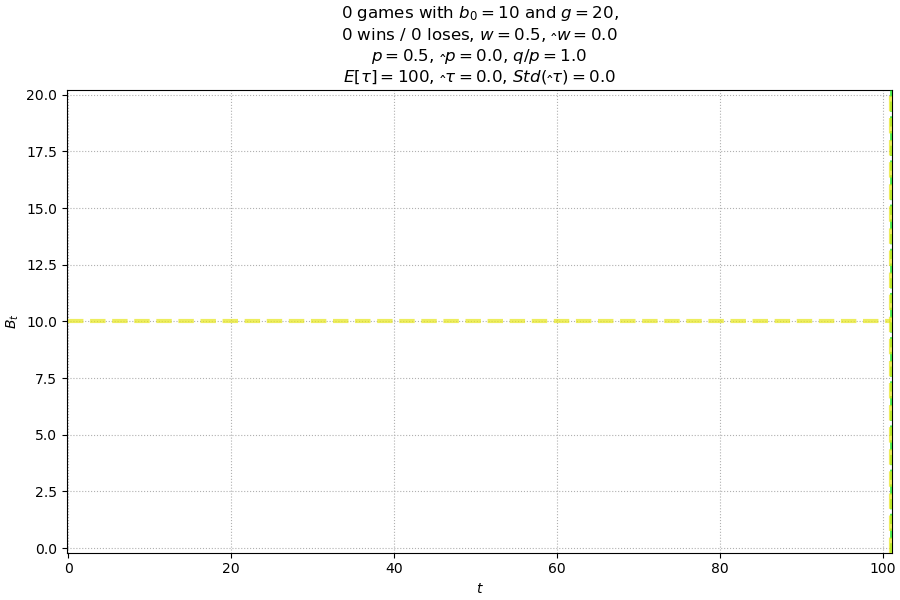

In [3]:
widget = GameWidget()
widget.show()